Scientists want to do "informative" experiments. What makes an experiment informative? I believe that information theory has a lot of answers. In this post I will try to explain information theory's definition of "how much information you get from an experiment" using d20 dice, assuming no previous knowledge of information theory.
<!-- TEASER_END -->

<div class="alert alert-info">
A tutorial like this has been on my writing list for a while now,
and today I decided to just GET IT DONE, so I made it into a "quickpost".
The quality is not quite as good as I hoped, but I think it is still better than nothing.
For more details on quickposts, see <a
href="/blog/2025-02-11-lowering-quality/">this blog post</a>.
</div>

## Intuition pump: a hidden d20 dice

The running scenario in this post will be a d20 (aka a fair 20-sided dice) which is rolled in secret (so you do not know the number).
We are trying to learn about the outcome of the dice.

Suppose I told you that this number is odd. Does that provide information?
Even though you still don't "know" the value of the dice with certainty,
your intuitive answer is probably "yes".
For example, you now know that the number is not "2", which you didn't know before.

Now for a more complex scenario. A second d20 is rolled. If the number is a "20",
this second d20 is rolled _again_ and you are told _that_ number.
Otherwise, you are told the number from the original dice.
Essentially this means you are told the secret number with 95% probability,
but with 5% probability you are told a random number. Is this informative?

Here I expect intuitions to be more mixed. On the one hand,
you are 95% certain to learn the true outcome of the dice.
On the other hand, you can never _eliminate_ any number:
if you hear the number "15" the true number could still be _anything_.

**By the end of this post** you will know that _both_ of these experiments _do_ provide
information, and in fact the second experiment is _more_ informative than the first one.

---

Below is some code which will be used to define the "experiments" on dice.

**NOTE**: this blog post is a runnable jupyter notebook.
Even though the text in this notebook assumes a d20,
you can change the size of the dice freely by setting the `D` variable below!

In [1]:
D = 20  # Change as desired, but D ≠ 20 will mean the numbers in text won't match the numbers from the code
DICE_OUTCOMES = list(range(1, D+1))

from collections import defaultdict, Counter
from typing import Any, Callable
import numpy as np
from matplotlib import pyplot as plt

# Some useful functions for later
def is_prime(n):
    return n > 1 and not any( (n%i) == 0 for i in range(2, int(n/2 + 1)))

def is_even(n):
    return (n%2) == 0

def prior_prob(f):
    return sum(1 for n in DICE_OUTCOMES if f(n)) / len(DICE_OUTCOMES)

## Definition information

The "information" of a random outcome is defined as the (base 2) logarithm of its probability of occuring.

$$I(X=x) = -\log_2 P(X=x)$$

Information is measured in _bits_. Here are some examples:

In [2]:
def information(p):
    I = -np.log2(p)
    return np.maximum(I, 0.0)  # this is just for numerical errors

print(f"1. I(x is even): -log2(1/2) = {information(prior_prob(is_even))} bits")
print(f"2. I(x is prime): there are 8 primes in [1, 20] -log2(8/20) ≈ {information(prior_prob(is_prime)):.2f} bits")
print(f"3. I(x is between 1 and 20): -log2(1) = {information(prior_prob(lambda x: 1 <= x <= 20)):.2f} bits")
print(f"4. I(dice is 20): -log2(1/20) ≈ {information(prior_prob(lambda x: x == 20)):.2f} bits")

1. I(x is even): -log2(1/2) = 1.0 bits
2. I(x is prime): there are 8 primes in [1, 20] -log2(8/20) ≈ 1.32 bits
3. I(x is between 1 and 20): -log2(1) = 0.00 bits
4. I(dice is 20): -log2(1/20) ≈ 4.32 bits


Hopefully these examples make a few things clear:

- Rarer outcomes contain a higher amount of information
- Because probabilities are always ≤ 1, $I(x)$ is never negative
- The smallest amount of information is 0, which occurs for a _certain_ outcome (hopefully this makes intuitive sense)

## Some statistical definitions and notation

Unfortunately, before proceeding any further it is necessary to clarify some notation and definitions. Please bear with me:
as you will see below, information depends on exactly what you know, don't know, and want to know. These are easily confused, and to reduce confusion I will stick to some very standard terms.

- **Random variables**: capital letters like $X,Y,Z$ will be used for _random variables_: variables which do not have a particular value.
- **The dice variable N**: from now on, the random variable $N$ will denote the _number on the dice_ (a value between 1 and 20).
- **Outcomes vs events**: an _outcome_ is a particular value of a random variable, and an _event_ is a _set_ of outcomes. These are not the same. In this post we will frequently learn about _events_. For example, learning that "the dice is even" means $N$ is in the set {2, 4, 6, 8, 10, 12, 14, 16, 18, 20}.
- **Other random variables**: information is a function of _outcomes_ only, _not_ events. To represent events like "the dice is even", we will define a _new_ random variable with a name like $X$ with a different set of possible outcomes (like {True, False} instead of {1, 2, ..., 20}. In most cases $X$ will be a deterministic function of $N$, but not always. In these cases, an _outcome_ of $X$ is equivalent to an _event_ in $N$.

## Entropy is _average_ information

The definition above allows you to quantify the information of an outcome _once you have learned it_.
The natural extension of information to _unknown_ outcomes is entropy, which is just the average amount of information you expect to obtain by observing a random variable $X$.

$$H(X) = \sum_{\text{outcomes }x} P(X=x) I(X=x) = -\sum_x P(X=x)\log_2{P(X=x)}$$

Notice that $H$ is a function of _a random variable_ (capital $X$), rather than a particular outcome. This is because all outcomes of $X$ (denoted with lowercase $x$) are _summed_.
Let's revisit the same examples as above.

In [3]:
def entropy(prob_dist: dict[Any, float]) -> float:
    """Compute entropy of a probability distribution"""
    probs = np.array(list(prob_dist.values()))
    assert np.isclose(probs.sum(), 1)
    probs = probs[probs > 0]  # Remove zero probabilities
    H = -np.sum(probs * np.log2(probs))
    return np.maximum(H, 0.0)  # for numerical errors

def function_to_prob_dict(f) -> dict[Any, float]:
    c = Counter([f(n) for n in DICE_OUTCOMES])
    return {outcome: count/D for outcome, count in c.items()}

print(f"1. H(x is even): -P(even)log2(P(even) - P(odd)log2(P(odd)) = -log2(1/2) = {entropy(function_to_prob_dict(is_even))} bits")
print(f"2. H(x is prime):                -(8/20)log2(8/20) - (12/20)log2(12/20) ≈ {entropy(function_to_prob_dict(is_prime)):.2f} bits")
print(f"3. H(x is between 1 and 20):                                 = -log2(1) = {entropy(function_to_prob_dict(lambda x: 1 <= x <= 20)):.2f} bits")

1. H(x is even): -P(even)log2(P(even) - P(odd)log2(P(odd)) = -log2(1/2) = 1.0 bits
2. H(x is prime):                -(8/20)log2(8/20) - (12/20)log2(12/20) ≈ 0.97 bits
3. H(x is between 1 and 20):                                 = -log2(1) = 0.00 bits


However, example #4 ("dice is 20") is more subtle because it can be interpreted as the outcome of multiple different random variables.
The choice of variable will give different entropy values.
Here are some examples:

In [4]:
print("4. H(x = 20)")
print(f"    a: X=N (the exact value of the dice):   H(X) ≈ {entropy(function_to_prob_dict(lambda x: x)):.2f} bits")
print(f"    b: X=1 if N=20, otherwise 0:            H(X) ≈ {entropy(function_to_prob_dict(lambda x: 1 if x == 20 else 0)):.2f} bits")
print(f"    c: X=1 if N=20, 2 if N=10, otherwise 0: H(X) ≈ {entropy(function_to_prob_dict(lambda x: {20: 1, 10: 2}.get(x, 0))):.2f} bits")
print("    d: ...")

4. H(x = 20)
    a: X=N (the exact value of the dice):   H(X) ≈ 4.32 bits
    b: X=1 if N=20, otherwise 0:            H(X) ≈ 0.29 bits
    c: X=1 if N=20, 2 if N=10, otherwise 0: H(X) ≈ 0.57 bits
    d: ...


This might feel counter-intuitive, since observing a value of 20 is the same in all cases.
The difference in entropy values is because _you do not know in advance whether you will observe a value of 20_!
Other observations will rule out this outcome. For example, in 4b you have a 19/20 chance of observing $X=0$ (aka "the dice is any value besides 20"). This is a very low-information outcome (≈0.07 bits), but is sufficient to deduce that the value is not 20.
In the other scenarios (4a or 4c) the other outcomes also rule out a value of 20, but are higher-information outcomes.

## Intuitively, entropy an information "requirement"

I've introduced entropy as an "average amount of information",
but intuitively it is a measure of _uncertainty_ about a variable.
The higher the entropy is, the more uncertain you are about a variable,
and therefore the more information you will _need_ to determine its value.
If you want to know something, high entropy is _bad_.

## Observations can change entropy

Let's re-use the random variable X from example 4b: $X=1$ if $N=20$, otherwise $X=0$.
We will introduce a _second_ random variable $Y$ to represent if $N$ is even: $Y=1$ if $N$ is even, otherwise $Y=0$.
Suppose we observe $Y=1$. How much information do we _gain_ about $X$?

We previously established that, without knowing $Y$, $H(X)\approx 0.29$ bits.
This value comes from the formula:

$$-P(X=1)\log_2{P(X=1)} - P(X=0)\log_2{P(X=0)} = -\frac{1}{20}\log_2{\frac{1}{20}} -\frac{19}{20}\log_2{\frac{19}{20}}\approx 0.29$$


Observing $Y=1$ rules out all odd values, of which there are 10. Therefore, _conditioned_ on this outcome, the probability of $N=20$ rises from 1/20 to 1/10. Hence, the new entropy of $X$ is:

$$H(X|Y=1) = -P(X=1|Y=1)\log_2{P(X=1|Y=1)} - P(X=0|Y=1)\log_2{P(X=0|Y=1)} = -\frac{1}{10}\log_2{\frac{1}{10}} -\frac{9}{10}\log_2{\frac{9}{10}}\approx 0.47$$

This is _higher_ than before: after this observation we are _more_ uncertain about the value of X.
This is reflected by the "uncertainty reduction" quantity:

$$H(X) - H(X|Y=1) \approx -0.18 \ ,$$

whose negative value means we have become ≈0.18 bits _less_ certain about X.

Consider however the other case, where we observe $Y=0$. In this case, $N$ is odd, so we know $N\neq 20$, implying $P(X=1)=0$. This means $X$ is known with certainty. In this case:

$$H(X|Y=0)= -0\times\log_2{0} -1\times\log_2{1}=0 \ , $$

so $H(X) - H(X|Y=0) = H(X) \approx 0.29$, implying _complete elimination of uncertainty in X_.

## Mutual information: the main measure of uncertainty reduction and information gain

Both the measurements above are _ex-post_ values: the change in uncertainty after a particular observation.
If we are choosing whether to observe $Y$, we do not know what we will observe!
Similar to the definition of entropy, we will define an _average_ value of uncertainty reduction.

$$I(X;Y) = \mathbb E_{y\sim P(Y)} \left [ H(X) - H(X|Y=y) \right]$$

Since $H(X)$ does not depend on $Y$, this can be simplified to

$$H(X) - \mathbb E_{y\sim P(Y)} \left [ H(X|Y=y) \right]\ .$$

This quantity is called _mutual information_. It turns out that mutual information is _never_ negative, which we can verify for the example above:

$$I(X;Y) = H(X) - \left[P(Y=1) H(X|Y=1) + P(Y=0) H(X|Y=0) \right] \approx 0.29 - 0.5\times (0.47) - 0.5\times 0 \approx 0.05$$

Because of this, mutual information can be viewed as both an amount of "uncertainty reduction" or an amount of "information gain".

## Exploring mutual information

The remainder of this notebook will go through a bunch of case studies of mutual information using code.
The function below implements mutual information in a slightly more complex way than what I explained above,
allowing for random functions (eg observe the dice with 95% probability, otherwise a random value).

In [5]:
def dice_mutual_information(
    f1: Callable[[int], dict[Any, float]],
    f2: Callable[[int], dict[Any, float]],
    dice_prob_dist: dict[Any, float] | None = None,
    explain: bool = False,
) -> float:
    """
    Mutual information for two probabilistic functions of the dice value
    (ie functions returning dict of outcome to probability dict).

    dice_prob_dist is the probability of observing different dice values
    (defaults to uniform).

    NOTE: the implementation is different than the H(X) - H(X|Y) description above.
    """

    # Call function and check values
    f1_calls = {n: f1(n) for n in DICE_OUTCOMES}
    f2_calls = {n: f2(n) for n in DICE_OUTCOMES}
    for d in (f1_calls, f2_calls):
        for outcome_to_probs in d.values():
            assert np.isclose(sum(outcome_to_probs.values()), 1)

    # Impute default dice probability distribution
    if dice_prob_dist is None:
        dice_prob_dict = {n: 1/len(DICE_OUTCOMES) for n in DICE_OUTCOMES}
    assert np.isclose(sum(dice_prob_dict.values()), 1.0)

    # Get set of unique outcomes to index the joint distribution
    f1_outcomes = sorted({outcome for d in f1_calls.values() for outcome in d})
    f2_outcomes = sorted({outcome for d in f2_calls.values() for outcome in d})

    # Built full joint distribution over f1 and f2 outcomes
    joint = np.zeros((len(f1_outcomes), len(f2_outcomes)))
    for n in DICE_OUTCOMES:
        for i1, x1 in enumerate(f1_outcomes):
            for i2, x2 in enumerate(f2_outcomes):
                joint[i1, i2] += (
                    dice_prob_dict[n] * 
                    f1_calls[n].get(x1, 0.0) *
                    f2_calls[n].get(x2, 0.0)
                )
    assert np.isclose(joint.sum(), 1.0)

    # Get marginals
    marginal_f1 = joint.sum(axis=1)
    marginal_f2 = joint.sum(axis=0)
    prod_of_marginals = np.outer(marginal_f1, marginal_f2)

    # Compute KL-divergence
    with np.errstate(divide="ignore"):
        log_term = np.log2(joint) - np.log2(prod_of_marginals)
        log_term = np.nan_to_num(log_term, nan=0.0, posinf=0.0, neginf=0.0)
    kl_terms = joint * log_term

    # Overall MI
    MI_value = max(
        float(kl_terms.sum()),
        0.0   # handle numerical errors
    )
    if explain:
        def _arr_entropy(arr):
            # Entropy of an array
            arr = arr[arr > 0]
            assert np.isclose(arr.sum(), 1)
            return np.maximum(-np.sum(arr * np.log2(arr)), 0.0)
        marginal_entropy = _arr_entropy(marginal_f1)
        print(f"Entropy of X1: {marginal_entropy:.4g} bits")
        mi_contribs = []
        for i, f2_outcome in enumerate(f2_outcomes):
            p_f2 = joint[:, i].sum()
            print(f"\tCase X2={f2_outcome}:\n\t  Prob:      {p_f2:+.4g}")
            if p_f2 > 0:
                h_f1_given_f2 = _arr_entropy(joint[:, i] / p_f2)
                print(f"\t  H(X1|X2):  {h_f1_given_f2:+.4g} bits")
                print(f"\t  Info gain: {marginal_entropy - h_f1_given_f2:+.4g} bits")
                mi_contrib = (marginal_entropy - h_f1_given_f2) * p_f2
            else:
                print("\t  Conditional entropy undefined for 0 probability event")
                mi_contrib = 0
            mi_contribs.append(mi_contrib)
    return MI_value

### Scenario 1: which variables produce most information about the value of a dice

We will look at the MI between $N$ and various other variables $X$.

In [6]:
def dice_value(n):
    return {n: 1.0}
print(f"MI between dice value and itself:          {dice_mutual_information(dice_value, dice_value):.3g}")
print(f"MI between dice value and even/odd:        {dice_mutual_information(dice_value, lambda n: {is_even(n): 1.0}):.3g}")
print(f"MI between dice value and prime/not prime: {dice_mutual_information(dice_value, lambda n: {is_prime(n): 1.0}):.3g}")
print(f"MI between dice value and constant:        {dice_mutual_information(dice_value, lambda n: {"A": 1.0}):.3g}")
print(f"MI between dice value and other dice:      {dice_mutual_information(dice_value, lambda n: {m: 1/len(DICE_OUTCOMES) for m in DICE_OUTCOMES}):.3g}")

MI between dice value and itself:          4.32
MI between dice value and even/odd:        1
MI between dice value and prime/not prime: 0.971
MI between dice value and constant:        0
MI between dice value and other dice:      0


Perhaps unsurprisingly, observing the value of the dice gives the most information about the value of the dice (and the mutual information of a variable with itself always equals the entropy).
Observing whether it is even or odd gives 1 bit of information.
Observing whether it is prime gives slightly less information.
Observing a constant gives no information.
Observing the roll of another dice also gives no information (since the probability distribution of outcomes is the same no matter what).

Now we will examine the question posed at the start of this post: how much information does "true value with probability p, random value with (1-p)" give?
Even though this is a random quantity, by Bayesian inference it will always result in a non-uniform distribution of belief over dice values, which will always have less entropy than a uniform distribuion.
The plot below compares this strategy to asking whether the dice is even or odd:

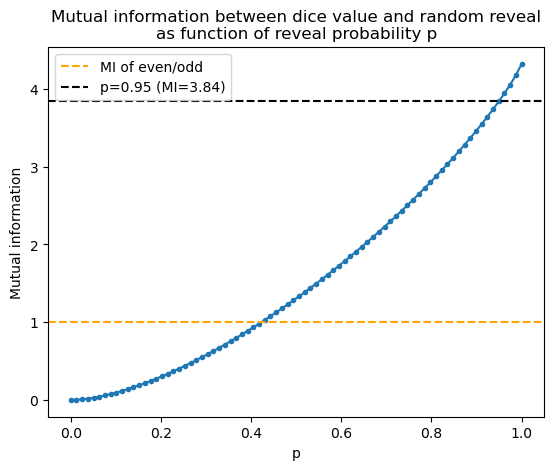

In [7]:
def show_value_with_prob_p(n, p):
    outcomes = {m: (1-p)/len(DICE_OUTCOMES) for m in DICE_OUTCOMES}
    outcomes[n] += p
    return outcomes

p_arr = np.linspace(0, 1, 80)
plt.plot(
    p_arr,
    [dice_mutual_information(dice_value, lambda n: show_value_with_prob_p(n, p)) for p in p_arr],
    ".-",
)
plt.xlabel("p")
plt.ylabel("Mutual information")
plt.title("Mutual information between dice value and random reveal\nas function of reveal probability p")
plt.axhline(1, linestyle="--", color="orange", label="MI of even/odd")
p095_val = dice_mutual_information(dice_value, lambda n: show_value_with_prob_p(n, 0.95))
plt.axhline(p095_val, linestyle="--", color="black", label=f"p=0.95 (MI={p095_val:.3g})")
plt.legend()
plt.show()

So, the answer to the question from the beginning of the post is that learning the dice value with 95% probability provides _dramatically_ more information than whether it is even or odd.
In fact, even if you only learned the dice value with _50%_ probability it would still give more.

### Scenario 2: testing for extreme values

A value will be considered "extreme" if N≤3 or N≥18. The probability of getting an extreme value
is 6/20, so its entropy will be fairly low. Let's see how different observations inform us about extreme outcomes.

In [8]:
def outcome_is_extreme(n):
    is_extreme = n <= 3 or n >= 18
    return {is_extreme: 1.0}

print(f"Entropy of extreme outcome:       {dice_mutual_information(outcome_is_extreme, outcome_is_extreme):.3g} bits")
print()
print(f"MI from exact dice value:         {dice_mutual_information(outcome_is_extreme, dice_value):.3g} bits")
print()
print(f"MI from learning even/odd:        {dice_mutual_information(outcome_is_extreme, lambda n: {is_even(n): 1.0}):.3g} bits")
print(f"MI from learning prime/not prime: {dice_mutual_information(outcome_is_extreme, lambda n: {is_prime(n): 1.0}):.3g} bits")
print(f"MI from learning ≤10:             {dice_mutual_information(outcome_is_extreme, lambda n: {n <= 10: 1.0}):.3g} bits")


def random_plus_minus_1(n):
    out = {n: 1/3, (n+1) % D: 1/3, (n-1) % D: 1/3}

    # Handle wrap-around case well
    if 0 in out:
        out[D] = out[0]
        del out[0]
    return out

print()
print(f"MI from learning value ±1:        {dice_mutual_information(outcome_is_extreme, random_plus_minus_1):.3g} bits")

print()
for m in range(3, 19):
    
    print(f"MI from learning value mod {m:>2d}:    {dice_mutual_information(outcome_is_extreme, lambda n: {n%m: 1.0}):.3g} bits")

Entropy of extreme outcome:       0.881 bits

MI from exact dice value:         0.881 bits

MI from learning even/odd:        0 bits
MI from learning prime/not prime: 0.0128 bits
MI from learning ≤10:             0 bits

MI from learning value ±1:        0.698 bits

MI from learning value mod  3:    0.00162 bits
MI from learning value mod  4:    0.0349 bits
MI from learning value mod  5:    0.0323 bits
MI from learning value mod  6:    0.206 bits
MI from learning value mod  7:    0.0548 bits
MI from learning value mod  8:    0.33 bits
MI from learning value mod  9:    0.406 bits
MI from learning value mod 10:    0.281 bits
MI from learning value mod 11:    0.281 bits
MI from learning value mod 12:    0.281 bits
MI from learning value mod 13:    0.281 bits
MI from learning value mod 14:    0.281 bits
MI from learning value mod 15:    0.481 bits
MI from learning value mod 16:    0.681 bits
MI from learning value mod 17:    0.881 bits
MI from learning value mod 18:    0.881 bits


This variable has much lower entropy than the dice value itself (≈0.9 bits instead of ≈4.3).
Of course, learning the dice value also tells you whether it is extreme.

Interestingly, while learning even/odd and prime/not prime gave ≈1 bit of information for the dice value,
they give almost no information about whether the value is extreme. Why is this?
In both cases, it is because the ratio of extreme : non-extreme values is similar regardless of the outcome.
For even:odd exactly 3:7 values are extreme for both even or odd numbers.
3/8 primes are extreme values while 3/12 non-primes are exteme.
Learning whether N≤10 is the same.

A noisy measurement of the dice value which has a 1/3 chance of being 1 too high and 1/3 chance of being 1 too low also provides almost all information:
this is not surprising, since only values of 3, 4, 17 or 18 will be uncertain.

Finally, modulo provides a lot of information depending on the modulo value.
Any value above 17 provides complete information (which should be clear if you think about it).
Intermediate values provide an intermediate value of information.
9 is an interesting local optimum which provides more value than learning the value mod 8 or mod 10.
Let's look into it with the `explain=True` kwarg:

In [9]:
dice_mutual_information(outcome_is_extreme, lambda n: {n%9: 1.0}, explain=True)

Entropy of X1: 0.8813 bits
	Case X2=0:
	  Prob:      +0.1
	  H(X1|X2):  +1 bits
	  Info gain: -0.1187 bits
	Case X2=1:
	  Prob:      +0.15
	  H(X1|X2):  +0.9183 bits
	  Info gain: -0.037 bits
	Case X2=2:
	  Prob:      +0.15
	  H(X1|X2):  +0.9183 bits
	  Info gain: -0.037 bits
	Case X2=3:
	  Prob:      +0.1
	  H(X1|X2):  +1 bits
	  Info gain: -0.1187 bits
	Case X2=4:
	  Prob:      +0.1
	  H(X1|X2):  +0 bits
	  Info gain: +0.8813 bits
	Case X2=5:
	  Prob:      +0.1
	  H(X1|X2):  +0 bits
	  Info gain: +0.8813 bits
	Case X2=6:
	  Prob:      +0.1
	  H(X1|X2):  +0 bits
	  Info gain: +0.8813 bits
	Case X2=7:
	  Prob:      +0.1
	  H(X1|X2):  +0 bits
	  Info gain: +0.8813 bits
	Case X2=8:
	  Prob:      +0.1
	  H(X1|X2):  +0 bits
	  Info gain: +0.8813 bits


0.40580214901434575

Here, 5/9 values (cumulative probability 0.5) completely rule out any extreme value.
The other values (0 to 4) slightly _increase_ the probability of a value being extreme, but overall the information gain works out to be large.

### Scenario 3: multi-stage tests

We will still try to determine whether a value is "extreme". However, instead of doing a single test, we will now perform a _series_ of tests,
represented by tuple values in code.

In [10]:
print(f"Entropy of extreme outcome: {dice_mutual_information(outcome_is_extreme, outcome_is_extreme):.3g} bits")
print()
print(f"MI of even/odd AND ≤10:     {dice_mutual_information(outcome_is_extreme, lambda n: {(n <= 10, is_even(n)): 1.0}):.3g} bits")
print(f"MI of n%5 and n%6:          {dice_mutual_information(outcome_is_extreme, lambda n: {(n%5, n%6): 1.0}):.3g} bits")
print(f"MI of n%3 and random ±1:    {dice_mutual_information(outcome_is_extreme, lambda n: {(n%3, k): v for k, v in random_plus_minus_1(n).items()}):.3g} bits")

Entropy of extreme outcome: 0.881 bits

MI of even/odd AND ≤10:     0.0349 bits
MI of n%5 and n%6:          0.881 bits
MI of n%3 and random ±1:    0.881 bits


All of these cases show that information is _non-additive_. The most obvious case is learning even/odd and ≤10.
Independently these both give ZERO information (shown in the previous subsection).
However, together they provide a small amount of information.
This is just because of the relative ratios of different outcomes changes.
To give an example, if the outcome `False, False` is observed,
the only extreme value is 19, whereas the non-extreme values are 11, 13, 15, 17.
The ratio of extreme values changes from 3/10 to 1/5, thereby providing an information gain.
The full table of outcomes is below.

In [11]:
dice_mutual_information(outcome_is_extreme, lambda n: {(n <= 10, is_even(n)): 1.0}, explain=True)

Entropy of X1: 0.8813 bits
	Case X2=(False, False):
	  Prob:      +0.25
	  H(X1|X2):  +0.7219 bits
	  Info gain: +0.1594 bits
	Case X2=(False, True):
	  Prob:      +0.25
	  H(X1|X2):  +0.971 bits
	  Info gain: -0.08966 bits
	Case X2=(True, False):
	  Prob:      +0.25
	  H(X1|X2):  +0.971 bits
	  Info gain: -0.08966 bits
	Case X2=(True, True):
	  Prob:      +0.25
	  H(X1|X2):  +0.7219 bits
	  Info gain: +0.1594 bits


0.034851554559677346

The last two examples show non-additivity. Firstly, even though learning n%5 and n%6 provides only
0.0323 bits and 0.206 bits respectively,
when observed together the number can be completely deduced.
This is because all numbers in 1 to 20 have a unique (n%5, n%6) tuple.
Similarly, even though n%3 provides only 0.00162 bits,
when combined with the noisy ±1 measurement it completely disambiguates the "boundary"
measurements of 3, 4, 17, and 18.

## Conclusion

This is the end of the tutorial, but please do play around with the notebook and write your own functions!